### MC Simulation BlackJack State-Value
---
- dealer policy: HIT17
- player policy: sticks on 20 or 21, otherwise hit
---
**States:** player's current sum(12–21), the dealer’s one showing card (ace–10), player's usable ace

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
class BlackJackMC(object):
    
    def __init__(self):
        self.player_state_value = {}
        self.player_states = []
        self.player_win = 0
        self.player_draw = 0
    
    # give card
    @staticmethod
    def giveCard():
        # 1 stands for ace
        c_list = list(range(1, 11)) + [10, 10, 10]
        return np.random.choice(c_list)
    
    def dealerPolicy(self, current_value, usable_ace, is_end):
        if current_value > 21:
            if usable_ace:
                current_value -= 10
                usable_ace = False
            else:
                return current_value, usable_ace, True
        # HIT17
        if current_value >= 17:
            return current_value, usable_ace, True
        else:
            card = self.giveCard()
            if card == 1:
                if current_value <= 10:
                    return current_value+11, True, False
                return current_value+1, usable_ace, False
            else:
                return current_value+card, usable_ace, False
            
    # one can only has 1 usable ace               
    def playerPolicy(self, current_value, usable_ace, is_end):
        if current_value > 21:
            if usable_ace:
                current_value -= 10
                usable_ace = False
            else:
                return current_value, usable_ace, True
        # HIT20
        if current_value >= 20:
            return current_value, usable_ace, True
        else:
            card = self.giveCard()
            if card == 1:
                if current_value <= 10:
                    return current_value+11, True, False
                return current_value+1, usable_ace, False
            else:
                return current_value+card, usable_ace, False
            
    
    def _giveCredit(self, player_value, dealer_value, is_end=True):
        if is_end:
            # give reward only to last state
            last_state = self.player_states[-1]
            if player_value > 21:
                if dealer_value > 21:
                    # draw
                    self.player_draw += 1
                else:
                    self.player_state_value[last_state] -= 1
            else:
                if dealer_value > 21:
                    self.player_state_value[last_state] += 1
                    self.player_win += 1
                else:
                    if player_value < dealer_value:
                        self.player_state_value[last_state] -= 1
                    elif player_value > dealer_value:
                        self.player_state_value[last_state] += 1
                        self.player_win += 1
                    else:
                        # draw
                        self.player_draw += 1
      
    
    def play(self, rounds=1000):
        for i in range(rounds):
            if i % 1000 == 0:
                print("round", i)
            # hit 2 cards each
            dealer_value, player_value = 0, 0
            show_card = 0

            # give dealer 2 cards and show 1
            dealer_value += self.giveCard()
            show_card = dealer_value
            dealer_value += self.giveCard()

            # player's turn
            # always hit if less than 12
            usable_ace, is_end = False, False
            while True:
                player_value, usable_ace, is_end = self.playerPolicy(player_value, usable_ace, is_end)

                if is_end: 
                    break
                # when value goes higher than 12, record states
                if (player_value >= 12) and (player_value <= 21):
                    self.player_states.append((player_value, show_card, usable_ace))
            # print("player card sum", player_value)

            # dealer's turn
            usable_ace, is_end = False, False
            while not is_end:
                dealer_value, usable_ace, is_end = self.dealerPolicy(dealer_value, usable_ace, is_end)
            # print("dealer card sum", dealer_value)

            # judge winner
            # set intermediate state to 0
            for s in self.player_states:
                self.player_state_value[s] = 0 if self.player_state_value.get(s) is None else self.player_state_value.get(s)

            self._giveCredit(player_value, dealer_value)      

In [3]:
b = BlackJackMC()
b.play(10000)

round 0
round 1000
round 2000
round 3000
round 4000
round 5000
round 6000
round 7000
round 8000
round 9000


In [151]:
print("Player wining rate", b.player_win/10000)
print("Not losing rate", (b.player_win+b.player_draw)/10000)

Player wining rate 0.306
Not losing rate 0.5497


#### Plots

Text(0.5, 0, 'reward')

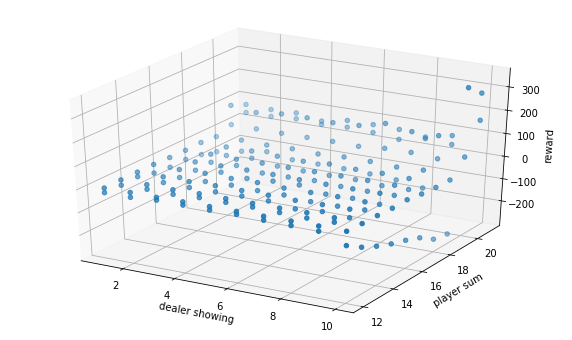

In [4]:
fig = plt.figure(figsize=[10, 6])
ax = fig.add_subplot(111, projection='3d')

x = [k[1] for k in b.player_state_value.keys()]
y = [k[0] for k in b.player_state_value.keys()]
z = [v for v in b.player_state_value.values()]
ax.scatter(x, y, z)

ax.set_xlabel("dealer showing")
ax.set_ylabel("player sum")
ax.set_zlabel("reward")

In [5]:
usable_ace = {}
nonusable_ace = {}

for k, v in b.player_state_value.items():
    if k[2]:
        usable_ace[k] = v
    else:
        nonusable_ace[k] = v

Text(0.5, 0, 'reward')

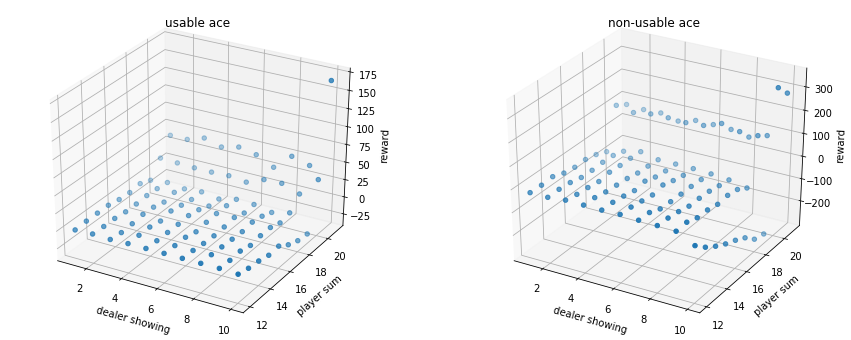

In [7]:
fig = plt.figure(figsize=[15, 6])

ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

x1 = [k[1] for k in usable_ace.keys()]
y1 = [k[0] for k in usable_ace.keys()]
z1 = [v for v in usable_ace.values()]
ax1.scatter(x1, y1, z1)

ax1.set_title("usable ace")
ax1.set_xlabel("dealer showing")
ax1.set_ylabel("player sum")
ax1.set_zlabel("reward")

x2 = [k[1] for k in nonusable_ace.keys()]
y2 = [k[0] for k in nonusable_ace.keys()]
z2 = [v for v in nonusable_ace.values()]
ax2.scatter(x2, y2, z2)

ax2.set_title("non-usable ace")
ax2.set_xlabel("dealer showing")
ax2.set_ylabel("player sum")
ax2.set_zlabel("reward")

In [9]:
b.player_state_value.get((18, 10, False))

-256

In [12]:
b.player_state_value.get((18, 5, False))

-52